## Implementing Portfolio Insurance (CPPI) and Drawdown constraints

Constant Porportion Portfolio Insurance (CPPI)

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

import edhec_risk_kit as erk
import numpy as np
import pandas as pd

# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [2]:
ind_return.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


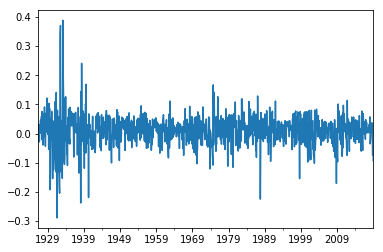

In [3]:
tmi_return.plot()

In [4]:
# risky asset
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]

In [5]:
risky_r.shape

(228, 3)

In [6]:
# Safe Asset with same shape trick
safe_r = pd.DataFrame().reindex_like(risky_r)

In [7]:
safe_r.shape

(228, 3)

## CCPI steps


1. Cushion - ( Asset value minus Floor Value
2. Compute an Allocation to Safe and Risky Assets --> m*risky budget
3. Recompute the Asset Value based on the returns



# Break from CCPI - detour to show efficiency topic with looping

In [8]:
# Proof : why no loop in python for effeciency

def compound_1(r):
    return (1+r).prod()-1

def compound_2(r):
    return np.exp(np.log(1+r).sum())-1 # this an implicit loop so numpy creates a new efficient function log1p(r)
    
def compound_21(r):
    return np.exp(np.log1p(r).sum())-1 # loop is pushing to numpy with log1p(r)

def compound_22(r):
    return np.expm1(np.log1p(r).sum()) # # loop is pushing to numpy with expm1

In [9]:
compound_1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [10]:
compound_2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [11]:
compound_21(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [12]:
compound_22(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [13]:
#smart way to measure time with average
%timeit compound_1(risky_r)

482 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit compound_22(risky_r)

448 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%timeit compound_21(risky_r)

588 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Back to CPPI

In [46]:
# CCPI set up parameters for the back test
safe_r[:] = .03/12
start = 1000
floor = 0.8

dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

# Variable to keep track of each value
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

# main
for step in range(n_steps):
    
    ## CCPI computation
    cushion = (account_value - floor_value)/account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1) # no leverage
    risky_w = np.maximum(risky_w, 0) # no short
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w # dollar value
    safe_alloc = account_value*safe_w # dollar value
    
    ## update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])

    ## save the value so we can look at the history and plot it etc
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value



In [47]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


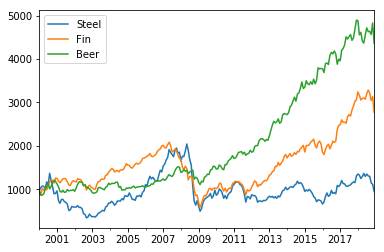

In [50]:
risky_wealth = start*(1+risky_r).cumprod()
risky_wealth.plot()

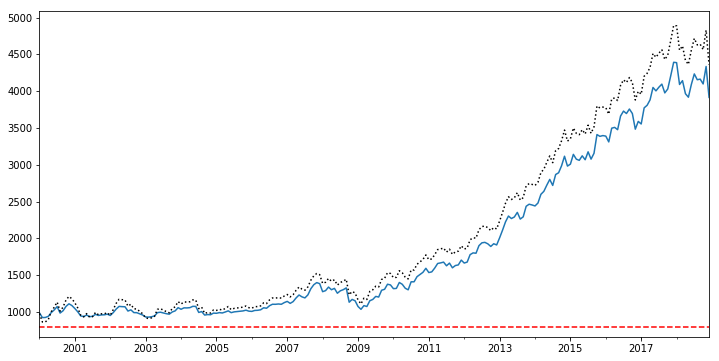

In [63]:
# check with the Beer
ax = account_history["Beer"].plot(figsize = (12,6))
risky_wealth["Beer"].plot(ax = ax, style="k:") # k: is black and dot
ax.axhline(y=floor_value, color = 'r', linestyle = "--") # create a line for the floor

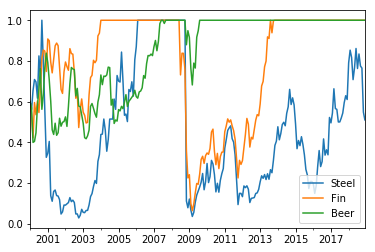

In [58]:
risky_w_history.plot()

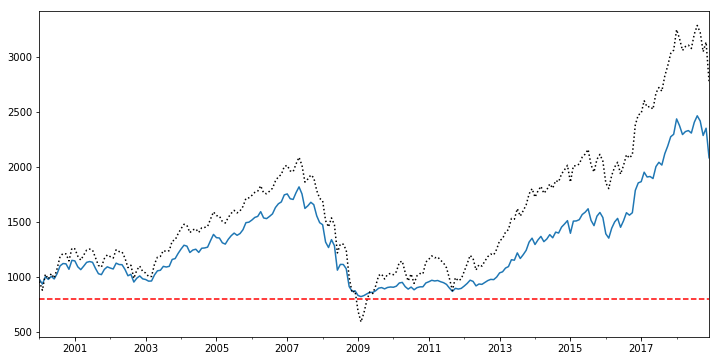

In [64]:
# check with the Fin
ind = "Fin"
ax = account_history[ind].plot(figsize = (12,6))
risky_wealth[ind].plot(ax = ax, style="k:") # k: is black and dot
ax.axhline(y=floor_value, color = 'r', linestyle = "--") # create a line for the floor

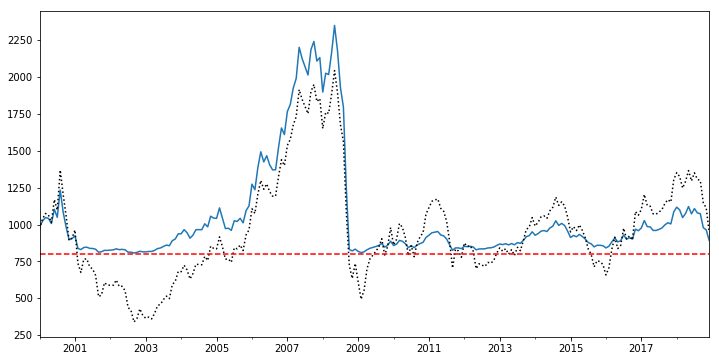

In [65]:
# check with the Fin
ind = "Steel"
ax = account_history[ind].plot(figsize = (12,6))
risky_wealth[ind].plot(ax = ax, style="k:") # k: is black and dot
ax.axhline(y=floor_value, color = 'r', linestyle = "--") # create a line for the floor

In [83]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [87]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


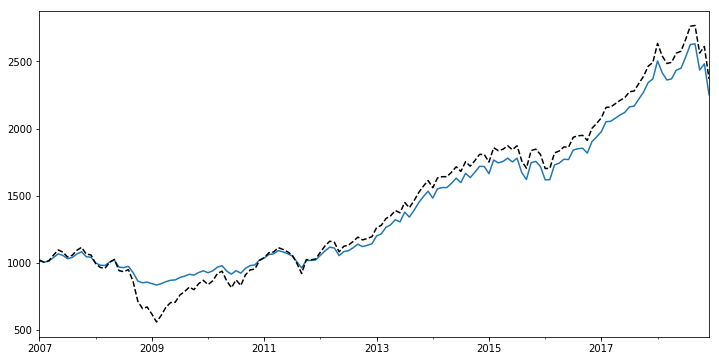

In [133]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize=(12,6), legend = False)
btr["Risky Wealth"].plot(ax = ax, style="k--", legend = False)

In [134]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [135]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


## Drawndown Constraint

In [138]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown = 0.25)

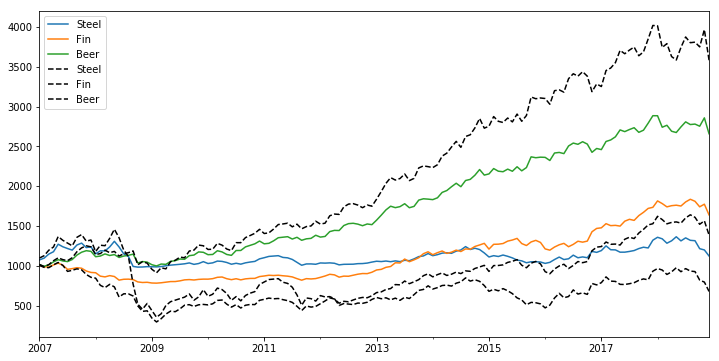

In [140]:
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax = ax, style="k--")

In [141]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [142]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
